In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow_hub as hub
import tensorflow.keras as keras
import os
from sklearn import model_selection, metrics, preprocessing
from bert_serving.client import BertClient
import pickle
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM, RNN
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

<h2> BERT Models </h2>

<b> SECTION 1: Relevance Model

In [12]:
trainX = pickle.load(open('./data/relevance_trainX.pkl', "rb"))
trainY = pickle.load(open('./data/relevance_trainY.pkl', "rb"))
testX = pickle.load(open('./data/relevance_testX.pkl', "rb"))
testY = pickle.load(open('./data/relevance_testY.pkl', "rb"))

We use the BERT Architecture to develop linguistic embeddings for the dataset that can subsequently be used in traditional machine learning and deep learning architectures to predict the label.
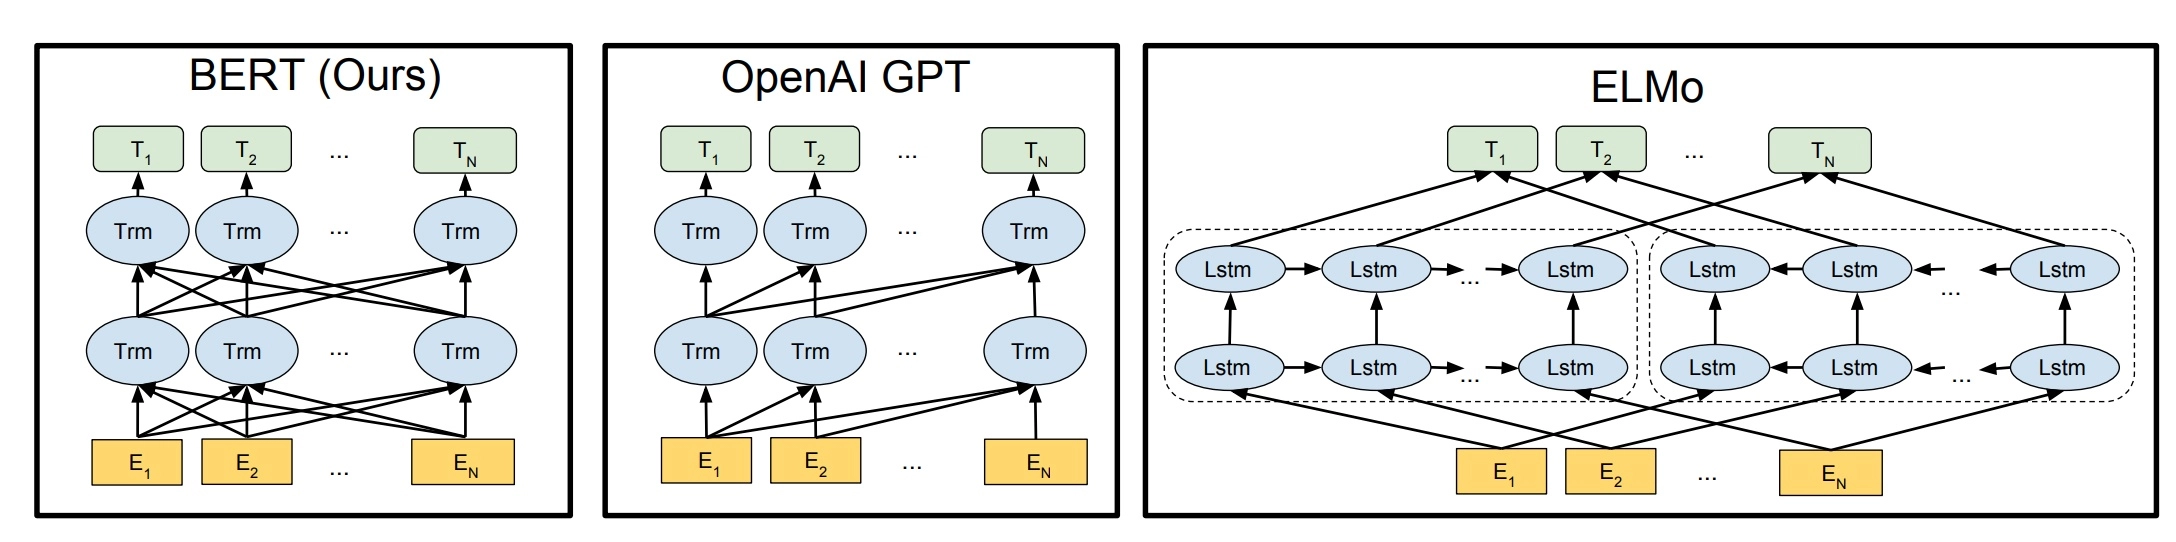

In [14]:
bc = BertClient()
trainX_bert = bc.encode(trainX.tolist())
testX_bert = bc.encode(testX.tolist())
validX_bert = trainX_bert[int(0.85*len(trainX_bert)):,:]
trainX_bert = trainX_bert[:int(0.85*len(trainX_bert)),:]
validY = trainY[len(trainX_bert):]
trainY = trainY[:len(trainX_bert)]
pickle.dump([trainX_bert, testX_bert, validX_bert], open('./data/bert_embeddings.pkl', 'wb'))

In [15]:
trainX_bert.shape, validX_bert.shape, testX_bert.shape

((3162, 768), (558, 768), (1240, 768))

The approach used here is fine-tuning BERT, where the linguistic "deeply-bidirectional" embeddings calculated above are used with an additional classification layer - LogisticRegression, RandomForestClassifier, ANN - and their performance checked on a validation set to decide a consolidated model.

In [16]:
def valid_visual(model):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    prec1, rec1, _ = metrics.precision_recall_curve(validY, model.predict_proba(validX_bert.copy())[:,1])
    plt.scatter(rec1, prec1)
    plt.subplot(1,2,2)
    tpr1, fpr1, _ = metrics.roc_curve(validY, model.predict_proba(validX_bert.copy())[:,1])
    plt.scatter(tpr1, fpr1)
    plt.show()
    print(metrics.classification_report(validY, model.predict(validX_bert.copy())))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 53.7min
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed: 74.9min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


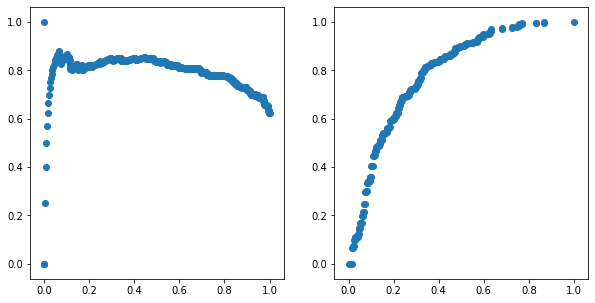

              precision    recall  f1-score   support

           0       0.65      0.70      0.67       228
           1       0.78      0.74      0.76       330

    accuracy                           0.72       558
   macro avg       0.71      0.72      0.72       558
weighted avg       0.73      0.72      0.72       558



In [18]:
#Logistic Regression and evaluation on validation data
lgparams = {'C':sp.stats.uniform(loc=1e-4, scale=1e4), 'solver':['saga'], 'random_state':[1], 
            'l1_ratio':sp.stats.uniform(), 'max_iter':[1000]}
mdl = LogisticRegression(penalty="elasticnet", class_weight="balanced", random_state=1)
lgmdl = model_selection.RandomizedSearchCV(mdl, lgparams, n_iter=100, cv=3, verbose=2, refit="neg_log_loss",
                           scoring=['brier_score_loss', 'neg_log_loss', 'roc_auc'], n_jobs=2, random_state=1)
lgmdl.fit(trainX_bert, trainY);
valid_visual(lgmdl)
pickle.dump(lgmdl, open('./data/bert-lgmdl.pkl', 'wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 66.8min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 164.4min
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed: 293.3min finished


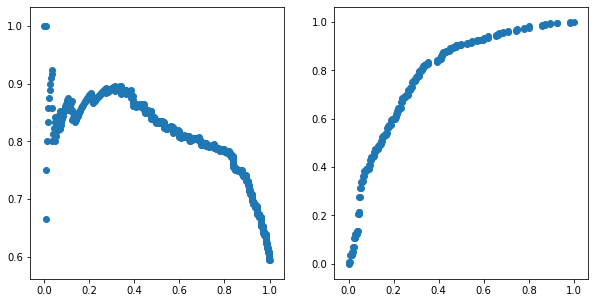

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       228
           1       0.78      0.82      0.80       330

    accuracy                           0.76       558
   macro avg       0.75      0.74      0.75       558
weighted avg       0.76      0.76      0.76       558



In [19]:
#Random Forest Classifier and evaluation on validation data
rfparams = {'n_estimators':[200], 'criterion':['gini', 'entropy'], 'max_depth':np.arange(10)+1, 
           'min_samples_split':[2,3,4,5,6], 'min_samples_leaf':[2,3,4,5,6], 
            'max_features':sp.stats.uniform(loc=0.5, scale=0.5), 
            'class_weight':['balanced', 'balanced_subsample']}
mdl = RandomForestClassifier(random_state=1)
rfmdl = model_selection.RandomizedSearchCV(mdl, rfparams, n_iter=100, cv=3, verbose=2, refit="neg_log_loss",
                           scoring=['brier_score_loss', 'neg_log_loss', 'roc_auc'], n_jobs=2, random_state=1)
rfmdl.fit(trainX_bert, trainY);
valid_visual(rfmdl)
pickle.dump(rfmdl, open('./data/bert-rfmdl.pkl', 'wb'))

In [ ]:
#Artificial Neural Network and evaluation on validation data
def build_mdr(nunits=60, l2reg=1e-3, drp=0.1):
    model = Sequential()
    model.add(Dense(nunits, activation=activ, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                   bias_regularizer=tf.keras.regularizers.l2(l2reg)))
    model.add(Dropout(drp))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='binary_crossentropy')
    return model